<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es9/Copy_of_AML_2023_HandsOn_9_AE_VAE_anomalydetection_FILLME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2022-2023
## Hands-on session 9

AE and VAE for anomaly detection

[SLIDE](https://jamboard.google.com/d/1z7dFUxIa2sWX6EfDDIWvmq3ZyWShX4pBjQfmX5ui044/edit?usp=sharing)

Modified implementation from original code from Antonio Norelli e Luca Moschella

In [10]:
# Install required packages.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.1+cu118


### MNIST dataset from pytorch datasets 

use images from digits 1 to 9 as training data and from digit 0 as anomalous dataset

In [11]:
dataset_train = datasets.MNIST(
    root = 'data', 
    train = True,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

dataset_test = datasets.MNIST(
    root = 'data', 
    train = False,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

dataset_anom = datasets.MNIST(
    root = 'data2', 
    train = False,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

print(dataset_train)
print(dataset_test)
print(dataset_anom)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data2
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
#extract digit 0 vs other digits

# exclude all digits but 0 from anom
index_anom = dataset_anom.targets == 0
dataset_anom.data, dataset_anom.targets = dataset_anom.data[index_anom], dataset_anom.targets[index_anom]

# exclude digit 0 from train and test
index_train = ((dataset_train.targets == 1) | (dataset_train.targets == 2) | (dataset_train.targets == 3) | (dataset_train.targets == 4) | 
               (dataset_train.targets == 5) | (dataset_train.targets == 6) | (dataset_train.targets == 7) | (dataset_train.targets == 8)| 
               (dataset_train.targets == 9))
index_test = ((dataset_test.targets == 1) | (dataset_test.targets == 2) | (dataset_test.targets == 3) | (dataset_test.targets == 4) | 
              (dataset_test.targets == 5) | (dataset_test.targets == 6) | (dataset_test.targets == 7) | (dataset_test.targets == 8)| 
              (dataset_test.targets == 9))

dataset_train.data, dataset_train.targets = dataset_train.data[index_train], dataset_train.targets[index_train]
dataset_test.data, dataset_test.targets = dataset_test.data[index_test], dataset_test.targets[index_test]

print(dataset_anom)
print(dataset_train)
print(dataset_test)

Dataset MNIST
    Number of datapoints: 980
    Root location: data2
    Split: Test
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 54077
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 9020
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# dataloaders

batch_size = 256
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True)
anom_dataloader = DataLoader(dataset_anom, batch_size=1, shuffle=True)

In [15]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=hidden_channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, 
                               out_channels=hidden_channels*2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7, 
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7, 
                                   out_features=latent_dim)
            
        self.activation = nn.ReLU()

    def forward(self, x):
    
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1) #flatten

        # prediction from the encoder: mu and logvariance
        # more stable wrt mu and sigma: https://stats.stackexchange.com/a/353222/284141 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

In [16]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim, 
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2, 
                                        out_channels=hidden_channels, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels, 
                                        out_channels=1, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        
        self.activation = nn.ReLU()
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [17]:
# Full AE/VAE Model

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder, hidden_channels=64, latent_dim=2):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        #VAE/AE
        if use_VAE:
          latent = self.latent_sample(latent_mu, latent_logvar)
        else:
          latent = latent_mu
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    # sampling function (implements the reparametrization trick)
    def latent_sample(self, mu, logvar):
        if self.training:
           #we need to sample from a gaussian in a way we can train the distribution paramenter  # logvar -> sigma
            eps =  # sample a normal distribution of the appropriate size 

            # reparameterization trick, using troch probability distributions package
            return # a gaussian oh mean(x) and sigma(x)
        else:
            return mu

In [18]:
# Instanziate and print the model

encoder = Encoder(hidden_channels=64, 
                  latent_dim=2)
decoder = Decoder(hidden_channels=64, 
                  latent_dim=2)
model_vae = VAE(encoder, decoder, hidden_channels=64, latent_dim=2)

print(model_vae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_vae.cuda(), input_size=(1,28,28))
else:
  summary(model_vae, input_size=(1,28,28))

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=6272, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=6272, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128

In [19]:
# Loss reco + KLD

beta_par = 1.0

# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    if use_VAE:
      # closed form of KL divergence for normal priors
      kldivergence =# adapt the formula in the slide for a prior N(0,1)
    else:
      kldivergence = 0.0
    return recon_loss + beta_par * kldivergence

In [20]:
# Training

encoder = Encoder(hidden_channels=64, 
                  latent_dim=2)
decoder = Decoder(hidden_channels=64, 
                  latent_dim=2)

model_vae = VAE(encoder, decoder, hidden_channels=64, latent_dim=2)
model_vae = model_vae.to(device)


In [21]:
LR = 3.e-3
opt = torch.optim.Adam(params=model_vae.parameters(), lr=LR, weight_decay=1e-5)

In [22]:
import time

epochs = 40
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()
    
    # training step
    model_vae.train()
    train_loss = 0
    counter = 0

    for xb, yb in train_dataloader:
        counter += 1
        xb=xb.to(device)  

        xhat, mu, logvar = model_vae(xb)
        loss = vae_loss(xhat, xb, mu, logvar)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f" 
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 10.7654, train loss: 46623.239818
epoch: 2, time(s): 8.7026, train loss: 40583.844453
epoch: 3, time(s): 8.9512, train loss: 39665.688555
epoch: 4, time(s): 9.0176, train loss: 39261.750611
epoch: 5, time(s): 8.3739, train loss: 38956.582383
epoch: 6, time(s): 9.2651, train loss: 38750.186260
epoch: 7, time(s): 10.6554, train loss: 38539.186352
epoch: 8, time(s): 9.6269, train loss: 38423.248612
epoch: 9, time(s): 8.8506, train loss: 38215.853358
epoch: 10, time(s): 10.0829, train loss: 38153.715084
epoch: 11, time(s): 13.2401, train loss: 38022.163655
epoch: 12, time(s): 12.9672, train loss: 37909.825330
epoch: 13, time(s): 10.0549, train loss: 37871.762718
epoch: 14, time(s): 11.3564, train loss: 37810.192758
epoch: 15, time(s): 10.8762, train loss: 37737.194313
epoch: 16, time(s): 12.4414, train loss: 37623.499778
epoch: 17, time(s): 11.4750, train loss: 37601.491558
epoch: 18, time(s): 10.3877, train loss: 37558.894013
epoch: 19, time(s): 12.8934, train loss: 375

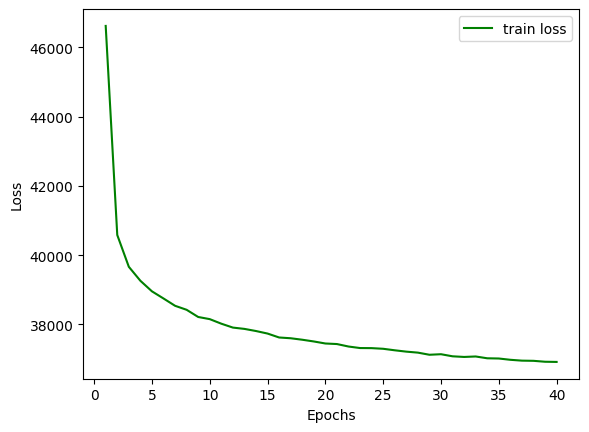

In [23]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# latent space plot
model_vae.eval()
z = np.empty(shape=(len(test_dataloader),2))
y = np.empty(shape=(len(test_dataloader)))
za =np.empty(shape=(len(anom_dataloader),2))
ya = np.empty(shape=(len(anom_dataloader)))
counter = 0
with torch.no_grad(): 
  for idx, (xb, yb) in enumerate(test_dataloader):
    xb=xb.to(device)  
    z_mean, _ = encoder(xb)
    z[idx,0] = z_mean[0,0].item()
    z[idx,1] = z_mean[0,1].item()
    y[idx] = yb.item()

  for idx, (xb, yb) in enumerate(anom_dataloader):
    xb=xb.to(device)  
    z_mean, _ = encoder(xb)
    za[idx,0] = z_mean[0,0].item()
    za[idx,1] = z_mean[0,1].item()
    ya[idx] = yb.item()

     

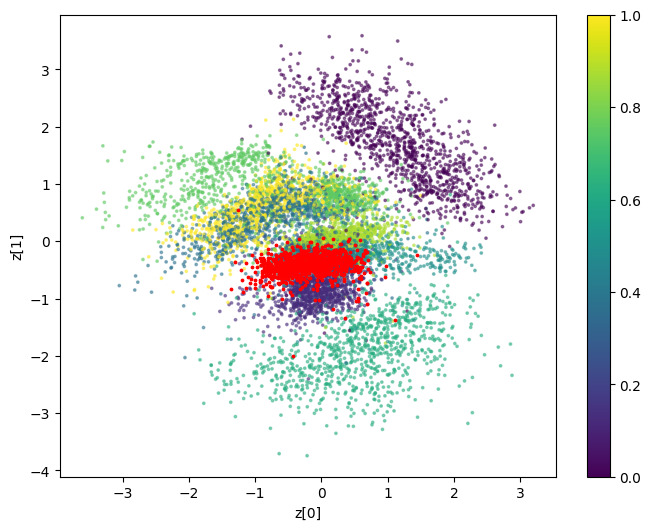

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=y,s=3,alpha = 0.5)
plt.scatter(za[:, 0], za[:, 1], c="r",s=3)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [26]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.9 MB/s eta 0:00:00


In [27]:
# check results agains normal and anomalous events

# let's use MSE as anomaly score

from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure().to(device)

# normal events
normal = []
model_vae.eval()
with torch.no_grad(): 
  for xb, yb in test_dataloader:
    xb=xb.to(device)  

    xhat, mu, logvar = model_vae(xb)
    ssim_m = ssim(xhat, xb)
    anomaly_score = ssim_m 
    #anomaly_score = F.mse_loss(xhat, xb)
    normal.append(anomaly_score.detach().item())

# anomalous events
anomalous = []
model_vae.eval()
with torch.no_grad(): 
  for xb, yb in anom_dataloader:
    xb=xb.to(device)  

    xhat, mu, logvar = model_vae(xb)
    ssim_m = ssim(xhat, xb)
    anomaly_score = ssim_m #F.mse_loss(xhat, xb)
    #anomaly_score = F.mse_loss(xhat, xb)
    anomalous.append(anomaly_score.detach().item()) 

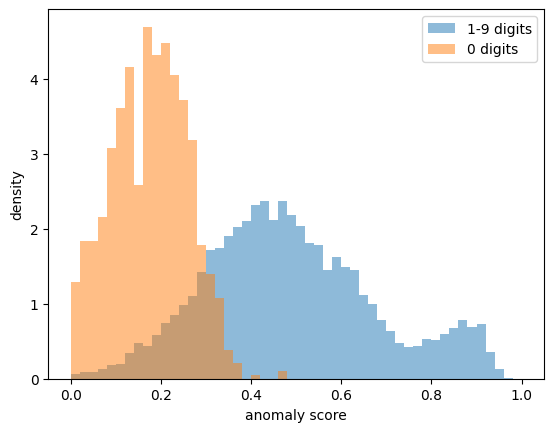

In [28]:
# plot histograms

_,_,_ = plt.hist(normal, bins=50, range=(0,1), density=True, alpha=0.5, label='1-9 digits')
_,_,_ = plt.hist(anomalous, bins=50, range=(0,1), density=True, alpha=0.5, label='0 digits')
plt.legend()
plt.xlabel('anomaly score')
plt.ylabel('density')
plt.legend()
plt.show()

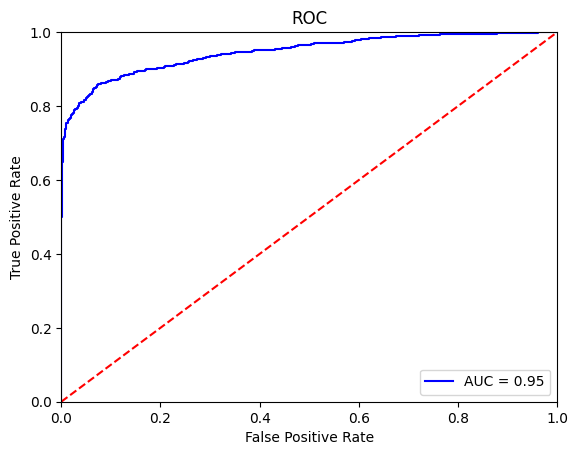

In [29]:
# ROC curve 0 VS 1-9

eve = len(anomalous)
# 
truth = np.zeros(shape=(2*eve))
truth[:eve] = 1 #set to class 1 the first eve events

score = np.zeros(shape=(2*eve))

for i in range(eve):
  score[i] = normal[i]
  score[i+eve] = anomalous[i]

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(truth, score)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  exercises

1.   compare results between AE and VAE
2.    try changing the anomalous target (1 instead of 0, and so on) 
3.    try other anomaly scores: for example SSIM (Structural similarity), or MAE etc...
4.    try to use as anomaly score not the output but the latent representation of the AVE: i.e. estimate probability that mu, sigma from each test events are consistent with the normal distributions representing the latent space learned by the model 
5.   try to use different datasets (for example some physics data ... provides links)  


```
#example: images of decays into a HEP detector of tracks from 
#prompt and displaced decays

#task: train on prompt, check anomalous displaced events
https://drive.google.com/file/d/1n1GXAJHWl979iBuFVQvoiPjLYu-kKiME/view?usp=sharing

https://drive.google.com/file/d/17BiHMlFfgRjPbTG3lATGgVh5DdcI0nks/view?usp=sharing

https://drive.google.com/file/d/1HaHh8Z6Xq8V-71fN6LuHzhKZwMXkr-am/view?usp=sharing

fil1 = np.load('MS_vertex_prompt2_2_v3.npz') 
fil2 = np.load('MS_vertex_prompt1_2_v3.npz')

labels1= fil1['labels']
labels2 = fil2['labels']
data_reso1 = fil1['data_noise']
data_reso2 = fil2['data_noise']

lr1 = labels1[:,0]
lr2 = labels2[:,0]

lr_prompt = np.concatenate((lr1, lr2), axis=0)
data_prompt = np.concatenate((data_reso1, data_reso2), axis = 0)

print("data_prompt shape :  ",data_prompt.shape)
print("lr_prompt shape :     ",lr_prompt.shape)

fil3 = np.load('MS_vertex_displ_2_v3.npz')
lr_displ= fil['labels']
data_displ = fil['data_noise']

print("data_displ shape :  ",data_displ.shape)
print("lr_displ shape :  ",lr_displ.shape)
```


6.   as usual play with the code/models etc...

In [ ]:
'''
 def latent_sample(self, mu, logvar):
        if self.training:
            sigma = (logvar * 0.5).exp()  # logvar -> sigma
            eps =torch.randn_like(sigma)

            # reparameterization trick, using troch probability distributions package
            return eps.mul(sigma).add_(mu)
        else:
            return mu


# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    if use_VAE:
      # closed form of KL divergence for normal priors
      kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
      kldivergence = 0.0
    return recon_loss + beta_par * kldivergence